# Define and plot BAM: best analogue of ERA5 event in CRCM5-LE 


### Packages and Directories

In [4]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
from statsmodels.stats.multitest import fdrcorrection
import calendar
from datetime import datetime, timedelta
import cftime

from scipy import ndimage

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [5]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/analogues/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
event_dir = '/home/alice/Desktop/work/git/myISACcode/python/analogues/analogue_data/event_data/'
BAM_dir = '/home/alice/Desktop/work/git/myISACcode/python/analogues/analogue_data/BAM_data/'

### Parameters

In [6]:
# Variables
var_analogues = 'psl'  # Variable for analogues

In [7]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 3
no_event = 3
str_event = f'node{no_node}-extreme{no_event}-{lselect}'
df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] - pd.Timedelta('6h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

In [8]:
# Quantile
qtl_LE = 0.99
no_analogues_LE = 18 # Number of analogues selected in each CRCM5 member

# Number of ensemble members
no_membs = 49
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members
print(list_membs)

# Epochs
year_range = [2004, 2023]

# Months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
month_names = [calendar.month_abbr[month] for month in months_sel]
str_months = ''.join([name[0] for name in month_names])

['kba', 'kbb', 'kbc', 'kbd', 'kbe', 'kbf', 'kbg', 'kbh', 'kbi', 'kbj', 'kbk', 'kbl', 'kbm', 'kbn', 'kbo', 'kbp', 'kbq', 'kbr', 'kbs', 'kbt', 'kbu', 'kbv', 'kbw', 'kbx', 'kby', 'kbz', 'kca', 'kcb', 'kcc', 'kcd', 'kce', 'kcf', 'kcg', 'kch', 'kci', 'kcj', 'kck', 'kcl', 'kcm', 'kcn', 'kco', 'kcp', 'kcq', 'kcr', 'kcs', 'kct', 'kcu', 'kcw', 'kcx']


### Upload Euclidean distance of analogues from event

In [9]:
# Load ensemble data
ensemble_data = {}
for memb in list_membs:
    # Construct the file path
    file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
    # Load the data from the npz file
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    # Load the data
    data = np.load(file_path, allow_pickle=True)
    times = data['times']
    distances = data['distances']
    ensemble_data[memb] = {'times': times, 'distances': distances}

# Load ERA5 data
file_path_ERA5 = f'./analogue_data/times_distances_analogues-mslp_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_2004-2023_ERA5.npz'
if not os.path.exists(file_path_ERA5):
    print(f"File not found: {file_path_ERA5}")
# Load the data
data_ERA5 = np.load(file_path_ERA5, allow_pickle=True)

In [10]:
# Distance from event
# CRCM5-LE distances
distances = np.zeros((no_membs, no_analogues_LE))  # Initialize distances array for plotting
for im, memb in enumerate(list_membs):
    # Extract distances for the current member and epoch
    distances[im] = ensemble_data[memb]['distances']
mean_dist = np.mean(distances)  # Calculate mean distance for the current epoch

# ERA5 distances
distances_ERA5 = data_ERA5['distances']

### N_BAM closest MSLP analogues in the model (BAM)

In [11]:
# Best analogues in model
N_BAM = 10  # Number of best analogues to find
# Flatten and sort distance array to get indices of smallest distances
flat_indices = np.argsort(distances, axis=None)
indices_minima = np.unravel_index(flat_indices, distances.shape)
# Extract member and time indices for the best analogues
ind_members = indices_minima[0][:N_BAM]
ind_extremes = indices_minima[1][:N_BAM]
# Retrieve corresponding member names
list_BAM_members = [list_membs[i] for i in ind_members]
# Retrieve corresponding dates
list_BAM_dates_noleap = [
    ensemble_data[list_BAM_members[i]]['times'][ind_extremes[i]]
    for i in range(N_BAM)
]
# Retrieve corresponding Euclidean distances
list_BAM_distances = [
    ensemble_data[list_BAM_members[i]]['distances'][ind_extremes[i]]
    for i in range(N_BAM)
]
# --- Output ---
print("Members and no-analogues in member:", list_BAM_members, ind_extremes)
print("Euclidean distances:", list_BAM_distances)
print("Dates:", [d.strftime("%Y-%m-%d") for d in list_BAM_dates_noleap])

## Save BAM info in function get_best_model_analogue_info() in file functions_analogues_PrMax.py ##

Members and no-analogues in member: ['kbw', 'kbi', 'kcw', 'kcs', 'kcw', 'kbx', 'kbi', 'kcd', 'kch', 'kbs'] [0 0 0 0 1 0 1 0 0 0]
Euclidean distances: [np.float32(37.11769), np.float32(37.529537), np.float32(38.53214), np.float32(41.776447), np.float32(42.616486), np.float32(42.89663), np.float32(43.3819), np.float32(43.86435), np.float32(44.195995), np.float32(45.161556)]
Dates: ['2011-12-05', '2022-11-10', '2004-10-22', '2018-12-09', '2017-11-30', '2019-11-05', '2005-10-11', '2007-11-14', '2014-12-14', '2013-10-30']


### Plot precipitation observed event

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


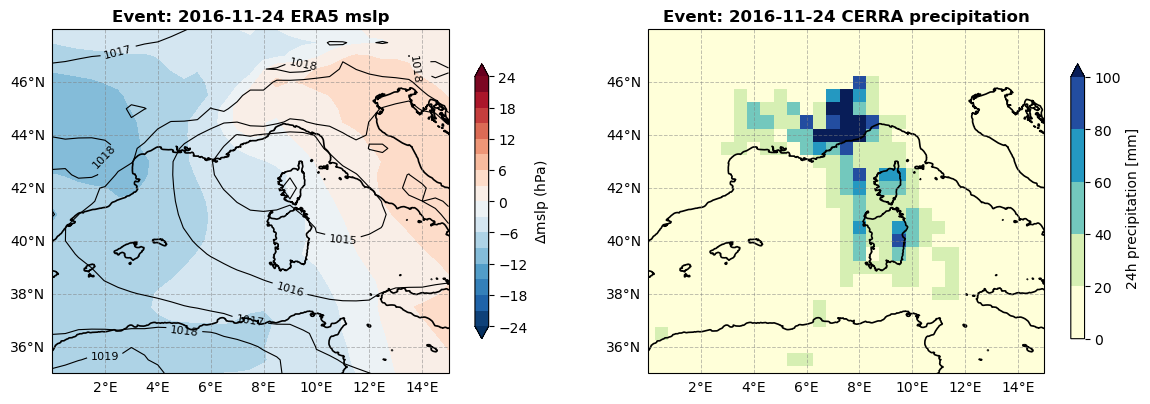

In [12]:
# data
# mslp
dmslp_event_ERA5 = fanPM.load_ERA5_data('mslp', 'daily', time_event+timedelta(hours=18), box_event, l_anom=True, data_dir=ERA5_dir+'mslp/')
mslp_clim_ERA5 = fanPM.load_ERA5_clim('mslp', doy_event, box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/')
dmslp_event_ERA5 = fanPM.regrid_with_xesmf(dmslp_event_ERA5, box_event, resolution=0.5)
mslp_clim_ERA5 = fanPM.regrid_with_xesmf(mslp_clim_ERA5, box_event, resolution=0.5)
# precip
precip_event_CERRA = fanPM.load_CERRA_precip(time_event, box_event, data_dir=CERRA_dir+'precip/')

# Plot
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6*2, 4),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot mslp
dmslp_levels = np.arange(-24,25,3)
fanPM.plot_anom_event(ax[0], 'mslp', dmslp_event_ERA5.lon, dmslp_event_ERA5.lat, dmslp_event_ERA5, mslp_clim_ERA5, f'Event: {time_event.strftime("%Y-%m-%d")} ERA5 mslp', levels=dmslp_levels)

# Plot precipitation
precip_levels = np.arange(0, 110, 20)
fanPM.plot_precipitation(ax[1], box_event, precip_event_CERRA, 
                         precip_levels=precip_levels, title=f'Event: {time_event.strftime("%Y-%m-%d")} CERRA precipitation')

plt.tight_layout()
# Save figure
fig.savefig(event_dir+f'mslp_pr_{str_event}_CERRA_ERA5.png', dpi=300)
plt.show()

### Connected precipitation mask

In [13]:
# Threshold: precip > pr_thresh
pr_thresh = 20  # mm/day
mask_pr = precip_event_CERRA > pr_thresh

# Label connected components
structure = np.ones((3,3))  # 8-connectivity
labeled_mask, num_features = ndimage.label(mask_pr, structure=structure)
labeled_mask = labeled_mask.astype(float)
labeled_mask[labeled_mask == 0] = np.nan

/tmp/ipykernel_22074/946191644.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_features)


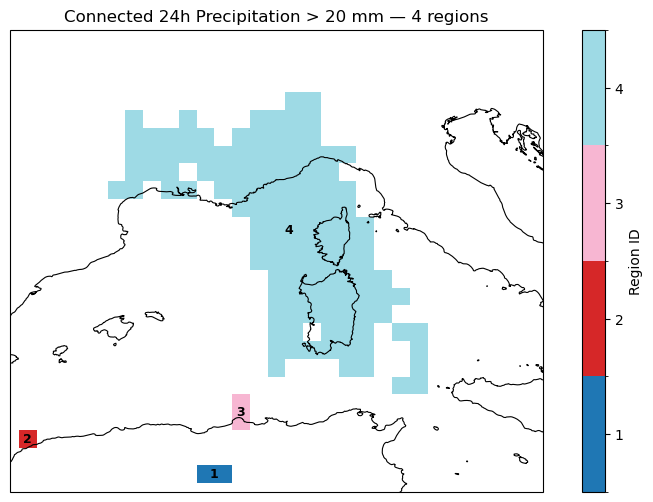

In [14]:
import matplotlib as mpl

fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot mask
cmap = plt.cm.get_cmap('tab20', num_features)
bounds = np.arange(0.5, num_features + 1.5, 1)  # boundaries between IDs
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = ax.pcolormesh(precip_event_CERRA.lon, precip_event_CERRA.lat, labeled_mask,
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(im, ax=ax, ticks=np.arange(1, num_features + 1))
cb.set_label("Region ID")

# Annotate IDs
for region_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_mask == region_id)
    if coords.size > 0:
        lat_mean = precip_event_CERRA.lat.values[coords[:, 0]].mean()
        lon_mean = precip_event_CERRA.lon.values[coords[:, 1]].mean()
        ax.text(lon_mean, lat_mean, str(region_id),
                color="black", ha="center", va="center",
                fontweight="bold", fontsize=9,
                transform=ccrs.PlateCarree())

ax.set_title(f"Connected 24h Precipitation > {pr_thresh} mm — {num_features} regions")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig(event_dir+'pr-regions_'+str_event+'_CERRA.png')

In [15]:
### Save mask of most-representative region ID
# Choice of labeled region ID to save
if no_node==1 and no_event==1:
    region_id = 1
elif no_node==6 and no_event==19:
    region_id = 4
elif no_node==5 and no_event==4:
    region_id = 4
elif no_node==3 and no_event==3:
    region_id = 4

# Create a mask where only region_id is kept, others set to 0
region_mask = np.where(labeled_mask == region_id, labeled_mask, 0)
region_mask = region_mask/region_mask.max()

# Convert to a DataArray
region_da = xr.DataArray(region_mask,
                          coords=precip_event_CERRA.coords,
                          dims=precip_event_CERRA.dims,
                          name=f'pr_mask')
region_da.to_netcdf(f'./analogue_data/event_data/pr-mask_'+str_event+'_CERRA.nc')

# Compute average precipitation in the region
mean_precip_in_region = precip_event_CERRA.where(region_da==1).mean().item()
print(f"Average precipitation in region ID {region_id}: {mean_precip_in_region} ")

Average precipitation in region ID 4: 46.715484619140625 


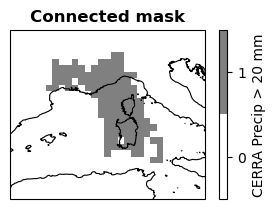

In [16]:
## Plot mask of most-representative region ID
fig, ax = plt.subplots(
    figsize=(3.5, 2.2),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot the region where region_da == 1
im = ax.pcolormesh(region_da.lon, region_da.lat, region_da == 1,
                   cmap=mpl.colors.ListedColormap(['white', 'grey']), transform=ccrs.PlateCarree())

# Add a colorbar with centered labels
cb = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cb.ax.set_yticklabels(['0', '1'])
cb.set_label(f"CERRA Precip > {pr_thresh} mm")

ax.set_title("Connected mask", fontsize=12, weight="bold")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig('./analogue_data/event_data/pr-mask_'+str_event+'_CERRA.png')

### Plot precip in N_BAM best analogues

In [17]:
# Load precip
precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, list_BAM_members, [[date] for date in list_BAM_dates_noleap])
# Make list of datasets and add 'member' coordinate
list_ds_pr = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
# Order list from alphabetical order of member to order in BAM_members
list_alphabetical_members = list(dict.fromkeys(sorted(list_BAM_members)))
list_ds_pr = [list_ds_pr[list_alphabetical_members.index(member)] for member in list_BAM_members]

# Select lon lat mask for the event
ds_tmp = list_ds_pr[0]
lon_mask, lat_mask = fanPM.lonlat_mask(ds_tmp.lon.values, ds_tmp.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": ds_tmp.lat.values, "lon": ds_tmp.lon.values},
)

# scale, choose date and select box
list_pr_BAM = []
for i, ds in enumerate(list_ds_pr):
    pr_tmp = ds['pr'] * 3600 # Convert from mm/s*24 to mm/day
    pr_tmp = pr_tmp.sel(time=list_BAM_dates_noleap[i] + timedelta(hours=12))
    pr_tmp = pr_tmp.where(mask_xr_BAM, drop=True)
    list_pr_BAM.append(pr_tmp.squeeze())


Opening files for member: kbi
Opening files for member: kbs
Opening files for member: kbw
Opening files for member: kbx
Opening files for member: kcd
Opening files for member: kch
Opening files for member: kcs
Opening files for member: kcw


In [18]:
# Load mslp
BAM_files, BAM_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5_bymonth(CRCM5_dir, var_analogues, list_BAM_members, [[time] for time in list_BAM_dates_noleap])
list_ds_dmslp = fanPM.open_member_datasets(BAM_files, combine='by_coords', expand_member_dim=True)
list_ds_mslp_clim = fanPM.open_member_datasets(BAM_files_clim, combine='by_coords', expand_member_dim=True)
# Order lists from alphabetical order of member to order in BAM_members
list_ds_dmslp = [list_ds_dmslp[list_alphabetical_members.index(member)] for member in list_BAM_members]
list_ds_mslp_clim = [list_ds_mslp_clim[list_alphabetical_members.index(member)] for member in list_BAM_members]

# Extract mslp for BAM dates
list_dmslp_BAM = []
list_mslp_BAM_clim = []
for i, ds in enumerate(list_ds_dmslp):
    dmslp_tmp = ds[var_analogues] * 0.01  # Scale from Pa to hPa
    dmslp_tmp = dmslp_tmp.sel(time=list_BAM_dates_noleap[i])
    dmslp_tmp = dmslp_tmp.where(mask_xr_BAM, drop=True)
    list_dmslp_BAM.append(dmslp_tmp.squeeze())
for i, ds in enumerate(list_ds_mslp_clim):
    mslp_tmp_clim = ds[var_analogues] * 0.01  # Scale from Pa to hPa
    doy_clim = mslp_tmp_clim.time.dt.dayofyear.values
    doy_BAM = list_BAM_dates_noleap[i].timetuple().tm_yday
    mask_time = doy_clim == doy_BAM
    mslp_tmp_clim = mslp_tmp_clim.sel(time=mask_time)
    mslp_tmp_clim = mslp_tmp_clim.where(mask_xr_BAM, drop=True)
    list_mslp_BAM_clim.append(mslp_tmp_clim.squeeze())

Opening files for member: kbi
Opening files for member: kbs
Opening files for member: kbw
Opening files for member: kbx
Opening files for member: kcd
Opening files for member: kch
Opening files for member: kcs
Opening files for member: kcw
Opening files for member: kbi
Opening files for member: kbs
Opening files for member: kbw
Opening files for member: kbx
Opening files for member: kcd
Opening files for member: kch
Opening files for member: kcs
Opening files for member: kcw


Mean precip in region for each BAM analogue: [np.float64(14.117014545342823), np.float64(10.293372644096056), np.float64(11.153618198151577), np.float64(21.389362494108532), np.float64(14.82052801928495), np.float64(12.192786837734442), np.float64(35.42101060969652), np.float64(19.36316663475516), np.float64(17.899557375613114), np.float64(12.634340109374007)]
Mean precip on land in region for each BAM analogue: [np.float64(25.85316662027495), np.float64(20.421060176264895), np.float64(22.359207261814717), np.float64(23.693282579567715), np.float64(19.91145447699312), np.float64(22.876579682468243), np.float64(38.14984415742854), np.float64(24.746831899191903), np.float64(22.834951619660952), np.float64(17.34920025920832)]


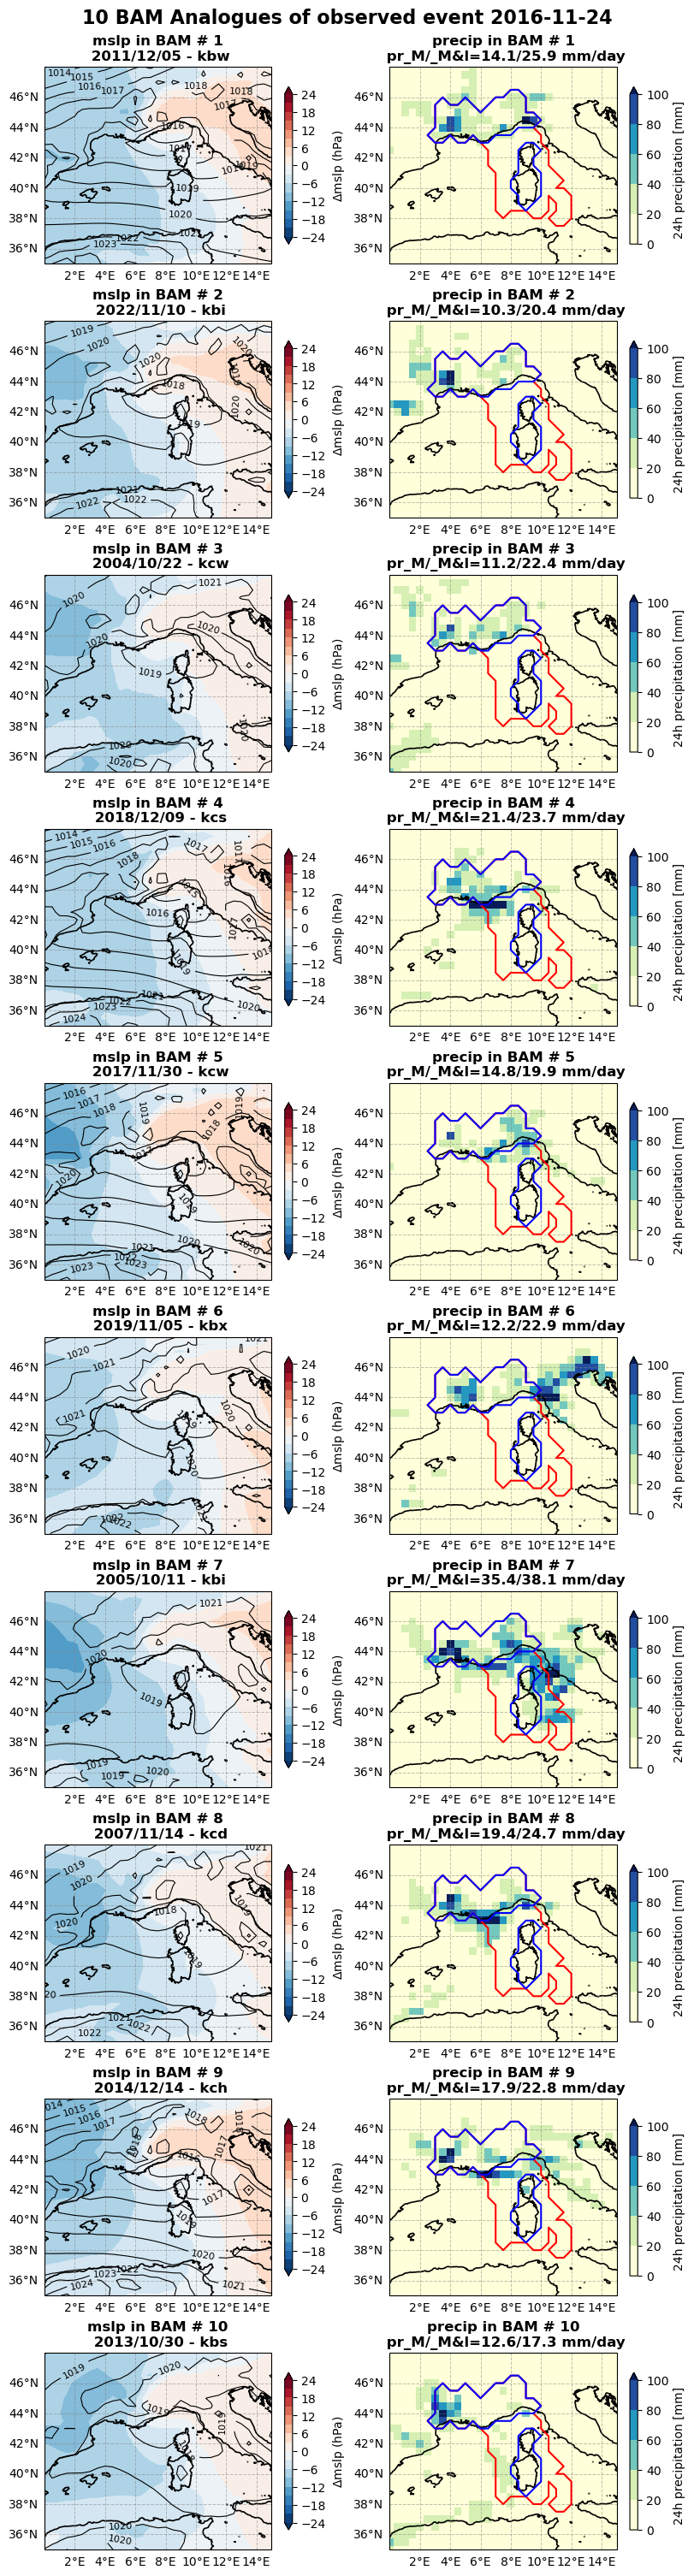

In [22]:
fig, ax = plt.subplots(
    nrows=N_BAM, ncols=2, figsize=(4*2, 3*N_BAM),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
    )
ax = ax.ravel()

# masks
pr_mask = xr.open_dataset(f'./analogue_data/event_data/pr-mask_{str_event}_CERRA.nc')['pr_mask']
lon = pr_mask.lon.values
lat = pr_mask.lat.values
land_mask = fanPM.create_land_mask(lon, lat).astype(int)
pr_mask_onland = pr_mask * land_mask


# lat weight for region average
weights = np.cos(np.deg2rad(pr_mask.lat))
weights_2d = weights.broadcast_like(pr_mask)

# Plot
list_pr_mask = []
list_pr_mask_onland = []
for i in range(N_BAM):
    # mean precip in region
    pr_masked = list_pr_BAM[i].where(pr_mask == 1)
    pr_masked_onland = pr_masked.where(pr_mask_onland == 1)
    pr_region = np.nansum(pr_masked * weights_2d) / np.nansum(weights_2d.where(~np.isnan(pr_masked)))
    pr_region_onland = np.nansum(pr_masked_onland * weights_2d) / np.nansum(weights_2d.where(~np.isnan(pr_masked_onland)))
    list_pr_mask.append(pr_region)
    list_pr_mask_onland.append(pr_region_onland)

    # Plot mslp anomaly
    i_mslp = i*2
    # Plot mslp
    dmslp_levels = np.arange(-24,25,3)
    fanPM.plot_anom_event(
        ax[i_mslp], 
        'mslp', 
        lon, lat, 
        list_dmslp_BAM[i], 
        list_mslp_BAM_clim[i], 
        f'mslp in BAM # {i+1}\n {list_BAM_dates_noleap[i].strftime("%Y/%m/%d")} - {list_BAM_members[i]}', 
        levels=dmslp_levels)

    # Plot precipitation
    i_pr = i*2 + 1
    pr_levels = np.arange(0, 110, 20)
    fanPM.plot_precipitation(
        ax[i_pr], 
        box_event, 
        list_pr_BAM[i], 
        pr_levels,
        f'precip in BAM # {i+1}\n pr_M/_M&l={pr_region:.1f}/{pr_region_onland:.1f} mm/day')
    # hatch region mask
    ax[i_pr].contour(
        pr_mask.lon, pr_mask.lat, pr_mask, 
        levels=[0], colors='red', linewidths=1.5, transform=ccrs.PlateCarree(), corner_mask=False
    )
    ax[i_pr].contour(
        pr_mask_onland.lon, pr_mask_onland.lat, pr_mask_onland, 
        levels=[0], colors='blue', linewidths=1.5, transform=ccrs.PlateCarree()
    )
    
fig.suptitle(f'10 BAM Analogues of observed event {time_event.strftime("%Y-%m-%d")}', fontsize=16, weight='bold')
fig.savefig(fig_dir+'psl_pr_10BAMs_'+str_event+'_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

print("Mean precip in region for each BAM analogue:", list_pr_mask)
print("Mean precip on land in region for each BAM analogue:", list_pr_mask_onland)


### Identifies BAM event in time and space (after BAM choice based on plot above)

In [19]:
# Best model analogue selection
str_BAM = f'BAM-node{no_node}-extreme{no_event}-{lselect}'
# Upload info on Best Model Analogue (BAM)
BAM_info, BAM_index = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
time_BAM = datetime.strptime(BAM_info['date'][BAM_index], "%Y-%m-%d")
time_BAM = cftime.DatetimeNoLeap(time_BAM.year, time_BAM.month, time_BAM.day, hour=0, minute=0, second=0)
doy_BAM = time_BAM.timetuple().tm_yday
member_BAM = BAM_info['member'][BAM_index]

# Event information
print('BAM member:', member_BAM)
print('BAM time:', time_BAM)
print('BAM DOY:', doy_BAM)
print('Event box:', box_event)

# Defines the months for analogue selection
month_BAM = time_BAM.month
months_sel = [month_BAM-1, month_BAM, month_BAM+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months_BAM = ''.join([name[0] for name in month_names])

# Months for analogue selection
print('Season (selection of 3 months) for BAM analogue search:', str_months_BAM)

# Year event
year_BAM = time_BAM.year

BAM member: kbi
BAM time: 2005-10-11 00:00:00
BAM DOY: 284
Event box: [0, 15, 35, 48]
Season (selection of 3 months) for BAM analogue search: SON


### Identify connected mask of 24h-precip > threshold

In [20]:
# Precip data for BAM
# Load precip
precip_file = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, [member_BAM], [[time_BAM]])
# Make list of datasets and add 'member' coordinate
ds_pr_BAM = fanPM.open_member_datasets(precip_file, combine='by_coords', expand_member_dim=True)[0]
# Select time and lon lat mask for the event
ds_pr_BAM = ds_pr_BAM.sel(time=time_BAM + timedelta(hours=12))
lon_mask, lat_mask = fanPM.lonlat_mask(ds_pr_BAM.lon.values, ds_pr_BAM.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": ds_pr_BAM.lat.values, "lon": ds_pr_BAM.lon.values},
)
ds_pr_BAM = ds_pr_BAM.where(mask_xr_BAM, drop=True)
# Scale from mm/s*24 to mm/day
pr_BAM = ds_pr_BAM['pr'].squeeze() * 3600


# Threshold: precip > pr_thresh
pr_thresh = 20  # mm/day
mask_pr = pr_BAM > pr_thresh

# Label connected components
structure = np.ones((3,3))  # 8-connectivity
labeled_mask, num_features = ndimage.label(mask_pr, structure=structure)
labeled_mask = labeled_mask.astype(float)
labeled_mask[labeled_mask == 0] = np.nan

Opening files for member: kbi


/tmp/ipykernel_22074/2789430104.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_features)


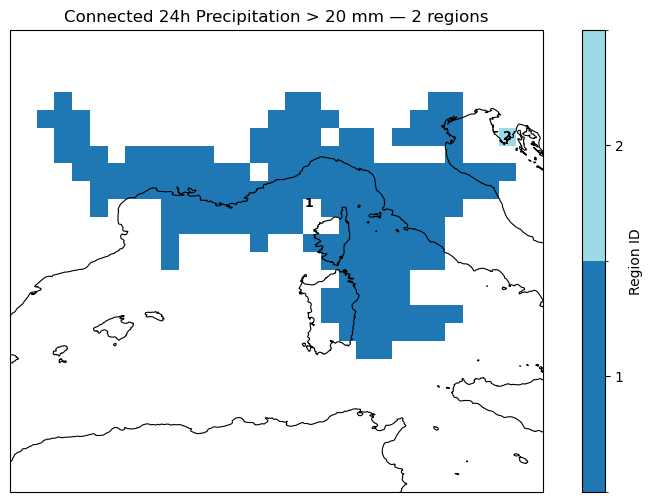

In [31]:
import matplotlib as mpl

fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot mask
cmap = plt.cm.get_cmap('tab20', num_features)
bounds = np.arange(0.5, num_features + 1.5, 1)  # boundaries between IDs
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = ax.pcolormesh(pr_BAM.lon, pr_BAM.lat, labeled_mask,
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(im, ax=ax, ticks=np.arange(1, num_features + 1))
cb.set_label("Region ID")

# Annotate IDs
for region_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_mask == region_id)
    if coords.size > 0:
        lat_mean = pr_BAM.lat.values[coords[:, 0]].mean()
        lon_mean = pr_BAM.lon.values[coords[:, 1]].mean()
        ax.text(lon_mean, lat_mean, str(region_id),
                color="black", ha="center", va="center",
                fontweight="bold", fontsize=9,
                transform=ccrs.PlateCarree())

ax.set_title(f"Connected 24h Precipitation > {pr_thresh} mm — {num_features} regions")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig(BAM_dir+'pr-regions_BAM-'+var_analogues+'_'+str_BAM+'_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Save mask of most-representative region ID

In [32]:
# Choice of labeled region ID to save
if no_node == 1 and no_event == 1:
    region_id = 3
elif no_node == 6 and no_event == 19:
    region_id = 1
elif no_node == 5 and no_event == 4:
    region_id = 1
elif no_node == 3 and no_event == 3:
    region_id = 1


# Create a mask where only region 5 is kept, others set to 0
region_mask = np.where(labeled_mask == region_id, labeled_mask, 0)
region_mask = region_mask/region_mask.max()

# Convert to a DataArray
region_da = xr.DataArray(region_mask,
                          coords=pr_BAM.coords,
                          dims=pr_BAM.dims,
                          name=f'pr_mask')
region_da.to_netcdf(f'./analogue_data/BAM_data/pr-mask_BAM-'+var_analogues+'_'+str_BAM+'_'+str_months_BAM+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.nc')

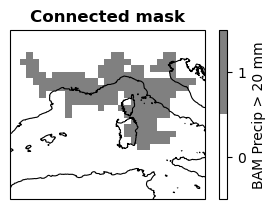

In [33]:
fig, ax = plt.subplots(
    figsize=(3.5, 2.2),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot the region where region_da == 1
im = ax.pcolormesh(region_da.lon, region_da.lat, region_da == 1,
                   cmap=mpl.colors.ListedColormap(['white', 'grey']), transform=ccrs.PlateCarree())

# Add a colorbar with centered labels
cb = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cb.ax.set_yticklabels(['0', '1'])
cb.set_label(f"BAM Precip > {pr_thresh} mm")

ax.set_title("Connected mask", fontsize=12, weight="bold")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig(BAM_dir+'pr-mask_BAM-'+var_analogues+'_'+str_BAM+'_'+str_months_BAM+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

In [35]:
str_months

'OND'

### Compute average precipitation in region mask

In [30]:
# Average precipitation in event region mask
mean_pr_BAM_in_mask = BAM_info['precip_in_event_20mm_mask'][BAM_index]
print(f"Average precipitation in obs event region: {mean_pr_BAM_in_mask:.2f} mm/day")

# Average precipitation in BAM region mask
weights = np.cos(np.deg2rad(pr_BAM.lat))
weights_2d = weights.broadcast_like(pr_BAM)
# mean precip in region
pr_BAM_masked = pr_BAM.where(region_da == 1)
mean_pr_BAM_in_BAM_mask = np.nansum(pr_BAM_masked * weights_2d) / np.nansum(weights_2d.where(~np.isnan(pr_BAM_masked)))
print(f"Average precipitation in BAM region: {mean_pr_BAM_in_BAM_mask:.5f} mm/day")

Average precipitation in obs event region: 35.42 mm/day
Average precipitation in BAM region: 46.46725 mm/day
